In [15]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [16]:
x, y = pkl.load(open('data/samples.pkl', 'rb'))

print(x.shape, y.shape)

(6288, 2278) (6288, 3)


In [17]:
roll, pitch, yaw = y[:, 0], y[:, 1], y[:, 2]

print(roll.min(), roll.max(), roll.mean(), roll.std())
print(pitch.min(), pitch.max(), pitch.mean(), pitch.std())
print(yaw.min(), yaw.max(), yaw.mean(), yaw.std())

-46.06486893 43.00866699 -0.52579503197042 5.176231116713095
-29.88856888 34.09674835 2.584682740273537 7.962828151857226
-75.55059814 86.84925079 -0.11620588007315523 13.090839183150852


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(4401, 2278) (4401, 3)
(943, 2278) (943, 3)
(944, 2278) (944, 3)


In [19]:
std = StandardScaler()
std.fit(x_train)
x_train = std.transform(x_train)
x_val = std.transform(x_val)
x_test = std.transform(x_test)

In [20]:
model = Sequential()
model.add(Dense(units=64, activation='relu', kernel_regularizer='l2', input_dim=x.shape[1]))
model.add(Dense(units=32, activation='relu', kernel_regularizer='l2'))
model.add(Dense(units=16, activation='relu', kernel_regularizer='l2'))
model.add(Dense(units=8, activation='relu', kernel_regularizer='l2'))
model.add(Dense(units=3, activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                145856    
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 27        
Total params: 148,627
Trainable params: 148,627
Non-trainable params: 0
_________________________________________________________________


In [21]:
callback_list = [EarlyStopping(monitor='val_loss', patience=50)]

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
hist = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=1, epochs=100, callbacks=callback_list)
model.save('models/faceangle.h5')

Epoch 1/100
4401/4401 [==============================] - 6s 1ms/step - loss: 82.5313 - accuracy: 0.5113 - val_loss: 62.3816 - val_accuracy: 0.6670
Epoch 2/100
4401/4401 [==============================] - 7s 2ms/step - loss: 50.3206 - accuracy: 0.6431 - val_loss: 44.6839 - val_accuracy: 0.6755
Epoch 3/100
4401/4401 [==============================] - 8s 2ms/step - loss: 49.5547 - accuracy: 0.6701 - val_loss: 53.3363 - val_accuracy: 0.6819
Epoch 4/100
4401/4401 [==============================] - 9s 2ms/step - loss: 44.7764 - accuracy: 0.6957 - val_loss: 46.5400 - val_accuracy: 0.7147
Epoch 5/100
4401/4401 [==============================] - 9s 2ms/step - loss: 49.9738 - accuracy: 0.6746 - val_loss: 44.3243 - val_accuracy: 0.6935
Epoch 6/100
4401/4401 [==============================] - 6s 1ms/step - loss: 42.7960 - accuracy: 0.6841 - val_loss: 50.1344 - val_accuracy: 0.6225
Epoch 7/100
4401/4401 [==============================] - 5s 1ms/step - loss: 42.8609 - accuracy: 0.6975 - val_loss: 43

Val loss:  45.695858001708984
Val Accuracy  0.6938559412956238


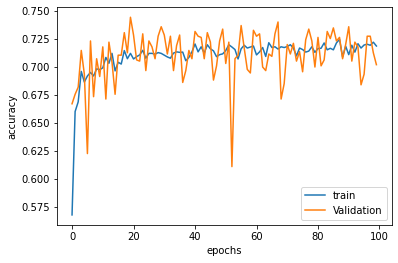

In [22]:
score = model.evaluate(x_test, y_test,verbose=0)
print('Val loss: ',score[0])
print('Val Accuracy ',score[1])
history = hist.history

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','Validation'])
plt.show()

TEST MODEL

In [23]:
def detect_face_points(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")
    face_rect = detector(image, 1)
    if len(face_rect) != 1: return []
    
    dlib_points = predictor(image, face_rect[0])
    face_points = []
    for i in range(68):
        x, y = dlib_points.part(i).x, dlib_points.part(i).y
        face_points.append(np.array([x, y]))
    return face_points
        
def compute_features(face_points):
    assert (len(face_points) == 68), "len(face_points) must be 68"
    
    face_points = np.array(face_points)
    features = []
    for i in range(68):
        for j in range(i+1, 68):
            features.append(np.linalg.norm(face_points[i]-face_points[j]))
            
    return np.array(features).reshape(1, -1)

Roll: -0.20°
Pitch: -1.90°
Yaw: 34.41°


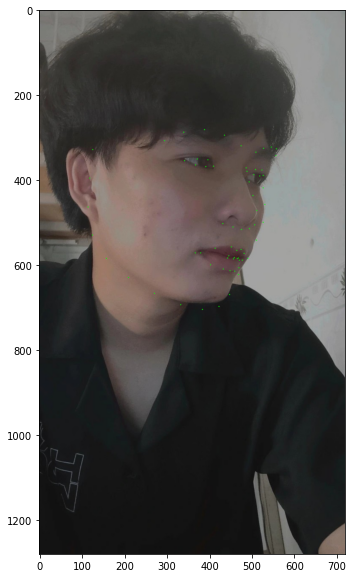

In [24]:
im = cv2.imread('image_test\PDuyPhong_1.jpg', cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
face_points = detect_face_points(im)

for x, y in face_points:
    cv2.circle(im, (x, y), 1, (0, 255, 0), -1)
    
features = compute_features(face_points)
features = std.transform(features)

model = load_model('models/faceangle.h5')
y_pred = model.predict(features)

roll_pred, pitch_pred, yaw_pred = y_pred[0]
print('Roll: {:.2f}°'.format(roll_pred))
print('Pitch: {:.2f}°'.format(pitch_pred))
print('Yaw: {:.2f}°'.format(yaw_pred))
    
plt.figure(figsize=(10, 10))
plt.imshow(im)